## F5500 Python Module

The F5500 python module makes it easier to download, store, read and manage the F5500 datasets published by the Department of Labor. The project is a work in progress.

This notebook is meant to show how a basic workflow using the module might look like.

To install the module run **pip install ./f5500** in the terminal.

To start, import the required libraries.

In [2]:
import f5500
import pandas as pd
import matplotlib.pyplot as plt

Use the module's **download** function to download specific schedules.

In [3]:
schedules_to_download = ["5500", "SCH_SB", "SCH_H"]

data = {}

for schedule in schedules_to_download:
        data[schedule] = f5500.download(schedule=schedule, year="2021", modality="Latest", overwrite=True, archive="Datasets")

Download complete.
    Date of modification: 2023-12-25
    File already exists in folder. Overwriting...
Download complete.
    Date of modification: 2023-12-25
    File already exists in folder. Overwriting...
Download complete.
    Date of modification: 2023-12-25
    File already exists in folder. Overwriting...


Check the newly created "Datasets" folder. Downloaded datasets will have been sent to a subfolder named after the datasets' upload date to the DOL's site.

If the data had already been downloaded, we could just **read** it from the local archive. If there's more than one version of the dataset downloaded we can specify which we want to use with argument **mod_date** (or default to "Latest").

In [ ]:
for schedule in schedules_to_download:
    data[schedule] = f5500.read(schedule=schedule, year='2021', modality='Latest', mod_date='Latest', archive='Datasets')

Merge main 5500 form to Schedules H and SB:

In [7]:
data["merged"] = pd.merge(data["5500"],
                          data["SCH_H"],
                          on="ACK_ID",
                          how="left")

data["merged"] = pd.merge(data["merged"],
                          data["SCH_SB"],
                          on="ACK_ID",
                          how="left")

print(data.keys())

dict_keys(['5500', 'SCH_SB', 'SCH_H', 'merged'])


With the data now merged, we can transform and query it to show the 10 largest sponsors by asset size, and their actuaries.

In [34]:
big_plans = (data["merged"]
             .query('TYPE_PENSION_BNFT_CODE.str.contains("1", na=False) and TYPE_PLAN_ENTITY_CD != 1')
             .groupby("SPONS_DFE_EIN")
             .agg({"TOT_ASSETS_EOY_AMT": "sum",
                   "SPONSOR_DFE_NAME": "first",
                   "SB_ACTUARY_FIRM_NAME": "first",
                   "TYPE_PLAN_ENTITY_CD": "first"})
             .assign(
                   Assets=lambda df: df["TOT_ASSETS_EOY_AMT"].apply("$ {:,.0f}".format),
                   Assets_ratio=lambda df: (df["TOT_ASSETS_EOY_AMT"] / df["TOT_ASSETS_EOY_AMT"].sum() * 100)
                   )
             .reset_index(drop=True)
             .sort_values("TOT_ASSETS_EOY_AMT", ascending=False)
             .drop(columns=["TOT_ASSETS_EOY_AMT"])
             .assign(Accumulated=lambda df: df["Assets_ratio"].cumsum()))

big_plans.head(10)

,SPONSOR_DFE_NAME,SB_ACTUARY_FIRM_NAME,TYPE_PLAN_ENTITY_CD,Assets,Assets_ratio,Accumulated
5659,THE BOEING CO. AND CONSOLIDATED SUBSIDIARIES,WILLIS TOWERS WATSON US LLC,2.0,"$ 67,563,651,657",2.369449,2.369449
1117,GENERAL ELECTRIC COMPANY,WILLIS TOWERS WATSON US LLC,3.0,"$ 61,006,772,240",2.139500,4.508950
3647,AT&T INC.,"AON CONSULTING, INC.",2.0,"$ 54,818,712,000",1.922486,6.431436
604,INTERNATIONAL BUSINESS MACHINES CORPORATION,WILLIS TOWERS WATSON US LLC,2.0,"$ 53,231,521,469",1.866823,8.298259
2260,GENERAL MOTORS LLC,WILLIS TOWERS WATSON US LLC,2.0,"$ 48,892,977,680",1.714671,10.012930
4692,FEDEX CORPORATION,MERCER,2.0,"$ 48,805,239,480",1.711594,11.724524
3144,FORD MOTOR COMPANY,WILLIS TOWERS WATSON US LLC,2.0,"$ 46,154,851,864",1.618645,13.343169
5959,"UNITED PARCEL SERVICE OF AMERICA, INC.",WILLIS TOWERS WATSON US LLC,2.0,"$ 42,905,226,133",1.504681,14.847850
5820,"KAISER FOUNDATION HEALTH PLAN, INC.","AON CONSULTING, INC.",2.0,"$ 38,075,941,703",1.335319,16.183169
5249,NORTHROP GRUMMAN CORPORATION,WILLIS TOWERS WATSON US LLC,2.0,"$ 37,344,149,646",1.309655,17.492824


Now we will look at the data from the actuarys' perspective and calculate some figures.

In [31]:

(data["merged"]
 .query('TYPE_PENSION_BNFT_CODE.str.contains("1", na=False) & (TYPE_PLAN_ENTITY_CD != 1)')
 .dropna(subset=["SB_ACTUARY_FIRM_NAME"])
 .assign(new_company=lambda df: (df["SB_ACTUARY_FIRM_NAME"].apply(
        lambda x: 'AON' if 'AON' in x 
        else 'MERCER' if 'MERCER' in x 
        else 'WTW' if any(keyword in x for keyword in ['WTW', 'WILLIS TOWERS', 'TOWERS WATSON']) 
        else None)))
 .dropna(subset=["SB_ACTUARY_FIRM_NAME"])
 .groupby("new_company")
 .agg({"TOT_ASSETS_EOY_AMT": "sum",
       "TOT_LIABILITIES_EOY_AMT": "sum",
       "TOT_PARTCP_BOY_CNT": "sum",
       "SPONS_DFE_EIN": "nunique",
       "SPONS_DFE_PN": "size"})
 .assign(
    AUM=lambda df: df["TOT_ASSETS_EOY_AMT"],
    Parts_ratio=lambda df: (df["TOT_PARTCP_BOY_CNT"] / df["TOT_PARTCP_BOY_CNT"].sum() * 100).apply("{:.2f}%".format),
    Assets_ratio=lambda df: (df["TOT_ASSETS_EOY_AMT"] / df["TOT_ASSETS_EOY_AMT"].sum() * 100).apply("{:.2f}%".format),
    aux=lambda df: (df["TOT_ASSETS_EOY_AMT"] / df["TOT_ASSETS_EOY_AMT"].sum() * 100),
    ratio=lambda df: (df["AUM"] / df["SPONS_DFE_EIN"]).apply("$ {:,.0f}".format)
    )
)

,TOT_ASSETS_EOY_AMT,TOT_LIABILITIES_EOY_AMT,TOT_PARTCP_BOY_CNT,SPONS_DFE_EIN,SPONS_DFE_PN,AUM,Parts_ratio,Assets_ratio,aux,ratio
new_company,,,,,,,,,,
AON,7.449697e+11,5.412642e+09,5481861.0,594,749,7.449697e+11,30.58%,31.29%,31.286627,"$ 1,254,157,730"
MERCER,4.075710e+11,4.069554e+09,3428545.0,482,611,4.075710e+11,19.13%,17.12%,17.116832,"$ 845,582,926"
WTW,1.228572e+12,1.862066e+10,9013571.0,825,1066,1.228572e+12,50.29%,51.60%,51.596542,"$ 1,489,177,646"


What's the smallest number of plan sponsors needed to cover 75% of all assets?

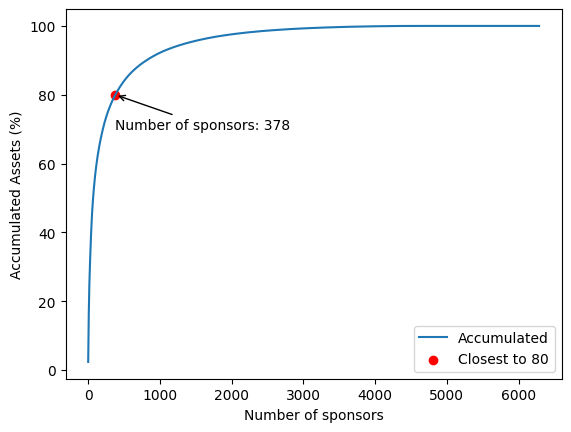

In [44]:
big_plans = big_plans.reset_index()

# Assuming df is your DataFrame
target_value = 80

# Find the index where "Accumulated" is closest to 75
closest_index = (big_plans["Accumulated"] - target_value).abs().idxmin()

# Plot the "Accumulated" column against the index
big_plans["Accumulated"].plot()

# Add a marker at the closest index
plt.scatter(closest_index, big_plans.loc[closest_index, "Accumulated"], color='red', label=f"Closest to {target_value}")

# Annotate the index number next to the marker
plt.annotate(f'Number of sponsors: {closest_index}', xy=(closest_index, big_plans.loc[closest_index, "Accumulated"]), xytext=(closest_index, big_plans.loc[closest_index, "Accumulated"] - 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.xlabel("Number of sponsors")
plt.ylabel("Accumulated Assets (%)")
plt.legend()
plt.show()